# Emotional numbing as a 5PL regression model

y = d + (a-d)/(1+(x/c)^b)^g

a theortical response at min</br>
b slope factor</br>
c mid range </br>
d therotical response at max</br>
g asymetrical factor</br>

Participants will rate pictures valence.</br>
We will fit a curve to the valence rating and "known" valence based on the mean from the dataset it was taken from.</br>
Hypothesis: </br>
    1. Depressive symptoms will be correlate with "d"</br>
    2. emotional numbing symptoms will correlate with increase of "b"

In [1]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az

import matplotlib.pyplot as ply
import seaborn as sns

create a single subject

<AxesSubplot:xlabel='x', ylabel='y'>

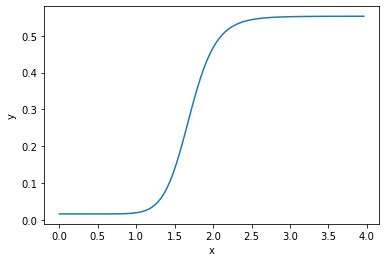

In [2]:
trials = 100
min_r = 0
max_r = 4
a = np.random.beta(1, 20, 1)[0]
b = np.random.normal(10, 2.5, 1)[0]
c = np.random.normal(2.5, .5, 1)[0]
d = np.random.beta(10, 10, 1)[0]
g = np.random.normal(1.1, .2, 1)[0]
x = np.arange(min_r, max_r, max_r/trials)
df = pd.DataFrame({'a': a,     
                   'b': b,    
                   'c': c,
                   'd': d,
                   'g': g,
                   'x': x})
df['y'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g

sns.lineplot(x='x',y='y',data=df)

In [3]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * df.x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_l = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


In [4]:
with pm.Model() as five_PL:
    
    a = pm.Beta('a', 1, 20)
    b = pm.Normal('b',10, 2.5)
    c = pm.Normal('c',2.5, .5)
    d = pm.Beta('d', 10, 10)
    g = pm.Normal('g', 1, .2)
    
    eps = pm.Exponential('eps', 5)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y'].values)
    trace_5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 479 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [6]:
with pm.Model() as five_PL_hier:
    
    # hyper prior per group
    mu_b = pm.Normal('mu_b', 6,    3)
    mu_c = pm.Normal('mu_c', 3.5,  1)
    mu_g = pm.Normal('mu_g', 1.1, .5)
    
    a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
    a2 = pm.Normal('a2', 20, 2)
    
    d1 = pm.Normal('d1', 12, 2)
    d2 = pm.Normal('d2', 8,  2)
    
    # priors
    
    a = pm.Beta('a',   a1, a2)
    b = pm.Normal('b', mu_b,   2)
    c = pm.Normal('c', mu_c,   5)
    d = pm.Beta('d',   d1, d2)
    g = pm.Normal('g', mu_g,  .2)
    
    
    eps = pm.Exponential('eps', 1)
    
    # model prediction using the 5PL regression    
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g

    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df.y)

    trace_PL5 = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1549 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [7]:
comp = az.compare({'Linear model': trace_l, '5PL model':trace_5, 'hier': trace_PL5}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hier,0,2342.159386,4.924699,0.000000,1.000000e+00,0.172681,0.000000,False,log
5PL model,1,2292.791027,0.825193,49.368359,0.000000e+00,0.169603,0.007153,False,log
Linear model,2,91.603867,2.130740,2250.555519,4.846856e-11,4.316058,4.281462,False,log


<AxesSubplot:xlabel='Log'>

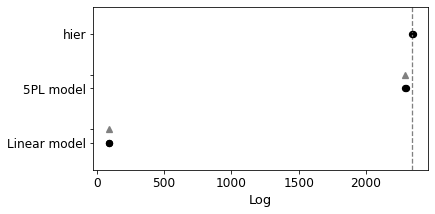

In [8]:
az.plot_compare(comp)

In [9]:
al = az.summary(trace_l, var_names=['a'])[['mean']]
bl = az.summary(trace_l, var_names=['b'])[['mean']]

df_l = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l['y'] = df_l.a + df_l.b * df_l.x

In [10]:
a5 = az.summary(trace_PL5, var_names=['a'])[['mean']]
b5 = az.summary(trace_PL5, var_names=['b'])[['mean']]
c5 = az.summary(trace_PL5, var_names=['c'])[['mean']]
d5 = az.summary(trace_PL5, var_names=['d'])[['mean']]
g5 = az.summary(trace_PL5, var_names=['g'])[['mean']]

df_5 = pd.DataFrame({'a': a5['mean'][0],     
                     'b': b5['mean'][0],    
                     'c': c5['mean'][0],
                     'd': d5['mean'][0],
                     'g': g5['mean'][0],
                     'x': x})

df_5['y'] = df_5.d + (df_5.a-df_5.d)/(1+(df_5.x/df_5.c)**df_5.b)**df_5.g

<AxesSubplot:xlabel='x', ylabel='y'>

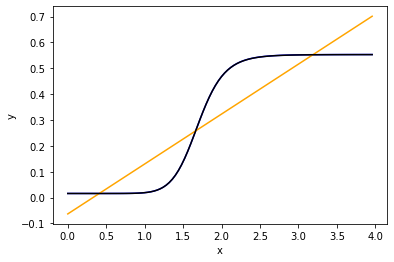

In [11]:
sns.lineplot(x='x',y='y',data=df, color = 'blue')
sns.lineplot(x='x',y='y',data=df_l, color = 'orange')
sns.lineplot(x='x',y='y',data=df_5, color = 'black')

No noise all models work great
if we add small noise?

<AxesSubplot:xlabel='x', ylabel='y_05'>

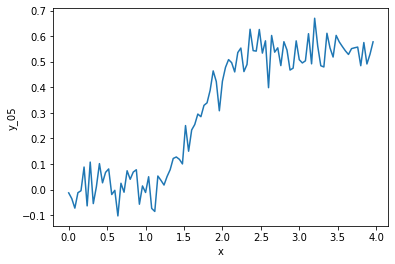

In [12]:
df['y_05'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g + np.random.normal(0, .05, trials)

sns.lineplot(x='x',y='y_05',data=df)

In [13]:
with pm.Model() as five_PL:
        
    
    # hyper prior per group
    mu_b = pm.Normal('mu_b', 6,    3)
    mu_c = pm.Normal('mu_c', 3.5,  1)
    mu_g = pm.Normal('mu_g', 1.1, .5)
    
    a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
    a2 = pm.Normal('a2', 20, 2)
    
    d1 = pm.Normal('d1', 12, 2)
    d2 = pm.Normal('d2', 8,  2)
    
    # priors
    
    a = pm.Beta('a',   a1, a2)
    b = pm.Normal('b', mu_b,   2)
    c = pm.Normal('c', mu_c,   5)
    d = pm.Beta('d',   d1, d2)
    g = pm.Normal('g', mu_g,  .2)
    
    
    eps = pm.Exponential('eps', 1)
    
    # model prediction using the 5PL regression    
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y_05'].values)
    
    trace_5_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 137 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
a5 = az.summary(trace_5_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_n, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y_05'>

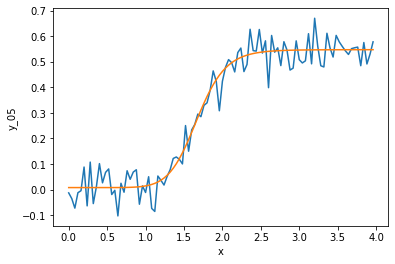

In [15]:
sns.lineplot(x='x',y='y_05',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

<AxesSubplot:xlabel='x', ylabel='y_1'>

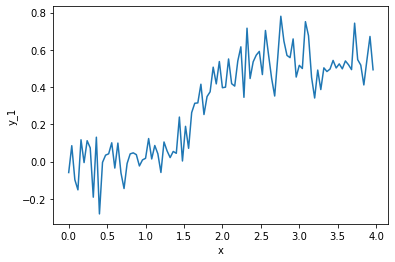

In [16]:
df['y_1'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g + np.random.normal(0, .1, trials)

sns.lineplot(x='x',y='y_1',data=df)

In [17]:
with pm.Model() as five_PL:
        
    
    # hyper prior per group
    mu_b = pm.Normal('mu_b', 6,    3)
    mu_c = pm.Normal('mu_c', 3.5,  1)
    mu_g = pm.Normal('mu_g', 1.1, .5)
    
    a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
    a2 = pm.Normal('a2', 20, 2)
    
    d1 = pm.Normal('d1', 12, 2)
    d2 = pm.Normal('d2', 8,  2)
    
    # priors
    
    a = pm.Beta('a',   a1, a2)
    b = pm.Normal('b', mu_b,   2)
    c = pm.Normal('c', mu_c,   5)
    d = pm.Beta('d',   d1, d2)
    g = pm.Normal('g', mu_g,  .2)
    
    
    eps = pm.Exponential('eps', 1)
    
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y_1'].values)
    
    trace_5_mn = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 82 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
a5 = az.summary(trace_5_mn, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_mn, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_mn, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_mn, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_mn, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y_1'>

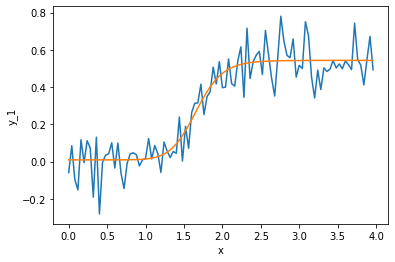

In [20]:
sns.lineplot(x='x',y='y_1',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

<AxesSubplot:xlabel='x', ylabel='y_2'>

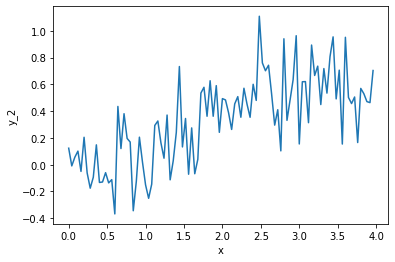

In [19]:
# Even more noise
df['y_2'] = df.d + (df.a-df.d)/(1+(df.x/df.c)**df.b)**df.g + np.random.normal(0, .2, trials)

sns.lineplot(x='x',y='y_2',data=df)

In [21]:
with pm.Model() as five_PL:
        
    # hyper prior per group
    mu_b = pm.Normal('mu_b', 6,    3)
    mu_c = pm.Normal('mu_c', 3.5,  1)
    mu_g = pm.Normal('mu_g', 1.1, .5)
    
    a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
    a2 = pm.Normal('a2', 20, 2)
    
    d1 = pm.Normal('d1', 12, 2)
    d2 = pm.Normal('d2', 8,  2)
    
    # priors
    
    a = pm.Beta('a',   a1, a2)
    b = pm.Normal('b', mu_b,   2)
    c = pm.Normal('c', mu_c,   5)
    d = pm.Beta('d',   d1, d2)
    g = pm.Normal('g', mu_g,  .2)
    
    
    eps = pm.Exponential('eps', 1)
    y_hat = d + (a-d)/(1+(df['x'].values/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=df['y_2'].values)
    
    trace_5_emn = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 78 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
a5 = az.summary(trace_5_emn, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_emn, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_emn, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_emn, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_emn, var_names=['g'])[['mean']]

df_5_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_n['y'] = df_5_n.d + (df_5_n.a-df_5_n.d)/(1+(df_5_n.x/df_5_n.c)**df_5_n.b)**df_5_n.g

<AxesSubplot:xlabel='x', ylabel='y_2'>

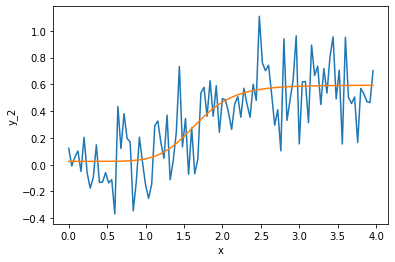

In [23]:
sns.lineplot(x='x',y='y_2',data=df)
sns.lineplot(x='x',y='y',data=df_5_n)

Can I fit a 5PL model to linear data?

<AxesSubplot:>

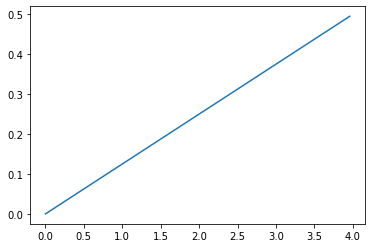

In [24]:
y = x/8
sns.lineplot(x=x,y=y)

In [25]:
with pm.Model() as five_PL:
        
    # hyper prior per group
    mu_b = pm.Normal('mu_b', 6,    3)
    mu_c = pm.Normal('mu_c', 3.5,  1)
    mu_g = pm.Normal('mu_g', 1.1, .5)
    
    a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
    a2 = pm.Normal('a2', 20, 2)
    
    d1 = pm.Normal('d1', 12, 2)
    d2 = pm.Normal('d2', 8,  2)
    
    # priors
    
    a = pm.Beta('a',   a1, a2)
    b = pm.Normal('b', mu_b,   2)
    c = pm.Normal('c', mu_c,   5)
    d = pm.Beta('d',   d1, d2)
    g = pm.Normal('g', mu_g,  .2)
    
    
    eps = pm.Exponential('eps', 1)
    y_hat = d + (a-d)/(1+(x/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    
    trace_5_lin = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 664 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.


In [26]:
a5 = az.summary(trace_5_lin, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_lin, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_lin, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_lin, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_lin, var_names=['g'])[['mean']]

df_5_lin = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_lin['y'] = df_5_lin.d + (df_5_lin.a-df_5_lin.d)/(1+(df_5_lin.x/df_5_lin.c)**df_5_lin.b)**df_5_lin.g

In [27]:
df_5_lin.head(1)

,a,b,c,d,g,x,y
0,0.015,1.342,11.411,0.992,3.016,0.0,0.015


<AxesSubplot:xlabel='x', ylabel='y'>

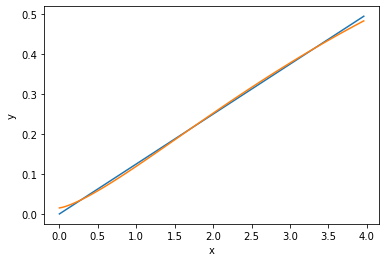

In [28]:
sns.lineplot(x=x,y=y)
sns.lineplot(x='x',y='y',data=df_5_lin)

<AxesSubplot:>

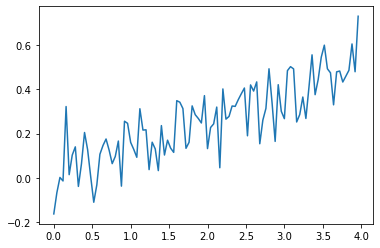

In [29]:
y = x/8 + np.random.normal(0, .1, trials)

sns.lineplot(x=x,y=y)

In [30]:
with pm.Model() as five_PL:
        
    # hyper prior per group
    mu_b = pm.Normal('mu_b', 6,    3)
    mu_c = pm.Normal('mu_c', 3.5,  1)
    mu_g = pm.Normal('mu_g', 1.1, .5)
    
    a1 = pm.TruncatedNormal('a1', 1, .5, lower = 0)
    a2 = pm.Normal('a2', 20, 2)
    
    d1 = pm.Normal('d1', 12, 2)
    d2 = pm.Normal('d2', 8,  2)
    
    # priors
    
    a = pm.Beta('a',   a1, a2)
    b = pm.Normal('b', mu_b,   2)
    c = pm.Normal('c', mu_c,   5)
    d = pm.Beta('d',   d1, d2)
    g = pm.Normal('g', mu_g,  .2)
    
    
    eps = pm.Exponential('eps', 1)
    y_hat = d + (a-d)/(1+(x/c)**b)**g
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    
    trace_5_lin_n = pm.sample(3000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, mu_c, mu_g, a1, a2, d1, d2, a, b, c, d, g, eps]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 121 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
with pm.Model() as linear:
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 1, 1)
    
    eps = pm.Exponential('eps', 5)
    y_hat = a + b * x
       
    # Likelihood (sampling distribution) of observations
    rating = pm.Normal('rating',y_hat, eps, observed=y)
    trace_l_n = pm.sample(2000, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


In [32]:
comp = az.compare({'Linear model': trace_l_n, '5PL model':trace_5_lin_n}, ic='loo')
comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Linear model,0,86.684636,3.071167,0.000000,1.000000e+00,7.046979,0.0000,False,log
5PL model,1,83.635031,4.157725,3.049605,8.881784e-16,6.948333,1.3565,False,log


In [33]:
a5 = az.summary(trace_5_lin_n, var_names=['a'])[['mean']]
b5 = az.summary(trace_5_lin_n, var_names=['b'])[['mean']]
c5 = az.summary(trace_5_lin_n, var_names=['c'])[['mean']]
d5 = az.summary(trace_5_lin_n, var_names=['d'])[['mean']]
g5 = az.summary(trace_5_lin_n, var_names=['g'])[['mean']]

df_5_lin_n = pd.DataFrame({'a': a5['mean'][0],     
                       'b': b5['mean'][0],    
                       'c': c5['mean'][0],
                       'd': d5['mean'][0],
                       'g': g5['mean'][0],
                       'x': x})

df_5_lin_n['y'] = df_5_lin_n.d + (df_5_lin_n.a-df_5_lin_n.d)/(1+(df_5_lin_n.x/df_5_lin_n.c)**df_5_lin_n.b)**df_5_lin_n.g

In [34]:
al = az.summary(trace_l_n, var_names=['a'])[['mean']]
bl = az.summary(trace_l_n, var_names=['b'])[['mean']]

df_l_n = pd.DataFrame({'a': al['mean'][0],     
                     'b': bl['mean'][0],    
                     'x': x})

df_l_n['y'] = df_l_n.a + df_l_n.b * df_l_n.x

<AxesSubplot:xlabel='x', ylabel='y'>

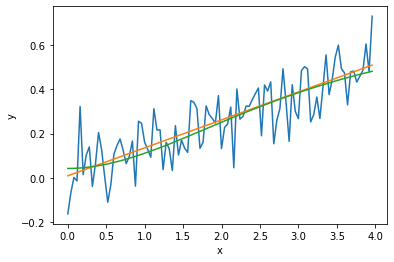

In [35]:
sns.lineplot(x=x,y=y)
sns.lineplot(x='x',y='y',data=df_l_n)
sns.lineplot(x='x',y='y',data=df_5_lin_n)